

## Sentiment Analysis using RNNs

# One-hot encoding of words

One-hot encoding is the most common, most basic way to turn a token (e.g., a word) into a vector. You already saw it in action in the IMDb example. One-hot encoding associates a unique integer index to every word, then
turns this integer index i into a binary vector of size N, the size of the vocabulary, that would be all-zeros except for the i-th entry, which would be 1.


Note that Keras has built-in utilities for doing one-hot encoding at the word level starting from raw text data.
This is what you should use as it will take care of a number of important things, such as stripping special characters
from strings, or only taking into account the top N most common words in your dataset (a common restriction to avoid dealing with very large input vector spaces).

Using Keras for word-level one-hot encoding:

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer

samples = ['The cat sat on the mat.', 'The dog ate my homework.']

# We create an instance of tokenizer, configured to only take
# into account the top 10000 most common words
tokenizer = Tokenizer(num_words=10000)

# This builds the word index
tokenizer.fit_on_texts(samples)

# This is how you can recover the word index that was computed above
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

# This turns strings into lists of integer indices
# Note: the lengths will be different: vectors of size 6 and 5, respectively
# FYI: If you only need to do one-hot-encoding, this line is not needed
sequences = tokenizer.texts_to_sequences(samples)

# You can directly get the one-hot-encoding vector as follows
# Note: the lengths will be identical: vectors of size 10000 for both samples,
# which is what we need for training our neural network
one_hot_results = tokenizer.texts_to_matrix(samples, mode='binary')


Found 9 unique tokens.


In [ ]:
word_index

{'the': 1,
 'cat': 2,
 'sat': 3,
 'on': 4,
 'mat': 5,
 'dog': 6,
 'ate': 7,
 'my': 8,
 'homework': 9}

In [ ]:
sequences

[[1, 2, 3, 4, 1, 5], [1, 6, 7, 8, 9]]

In [ ]:
one_hot_results

array([[0., 1., 1., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]])

# Using word embeddings

Another popular and powerful way to associate a vector with a word is the use of dense "word vectors," also called "word embeddings."
While the vectors obtained through one-hot encoding are binary, sparse (mostly made of zeros) and very high-dimensional (same dimensionality as the
number of words in the vocabulary), "word embeddings" are low-dimensional floating point vectors
(i.e. "dense" vectors, as opposed to sparse vectors).
Unlike word vectors obtained via one-hot encoding, word embeddings are **learned** from data.

It is common to see word embeddings that are 256-dimensional, 512-dimensional, or 1024-dimensional when dealing with very large vocabularies.
On the other hand, one-hot encoding words generally leads to vectors that are 20,000-dimensional or higher (capturing a vocabulary of 20,000
token in this case). So, word embeddings pack more information into far fewer dimensions.

![word embeddings vs. one hot encoding](https://s3.amazonaws.com/book.keras.io/img/ch6/word_embeddings.png)

There are two ways to obtain word embeddings:

* Learn word embeddings jointly with the main task you care about (e.g. document classification or sentiment prediction).
In this setup, you would start with random word vectors, then learn your word vectors in the same way that you learn the weights of a neural network.

* Transfer learning! Load into your model word embeddings that were pre-computed using a different machine learning task than the one you are trying to solve. These are called "pre-trained word embeddings."

In this class, we will focus on the first method, which is more straightforward.


## Learning word embeddings with the `Embedding` layer

The simplest way to associate a dense vector to a word would be to pick the vector at *random*. The problem with this approach is that the
resulting embedding space would have no structure: for instance, the words "awesome" and "amazing" may end up with completely different
embeddings, even though they are interchangeable in most sentences. It would be very difficult for a deep neural network to make sense of
such a noisy, unstructured embedding space.

To get a bit more abstract: the geometric relationships between word vectors should reflect the semantic relationships between these words.
Word embeddings are meant to map human language into a geometric space. For instance, in a reasonable embedding space, we would expect
synonyms to be embedded into similar word vectors, and in general we would expect the geometric distance (e.g. L2 distance) between any two
word vectors to relate to the semantic distance of the associated words (words meaning very different things would be embedded to points
far away from each other, while related words would be closer). In real-world word embedding spaces, common examples of meaningful geometric transformations are "gender vectors" and "plural vector". For
instance, by adding a "female vector" to the vector "king", one obtain the vector "queen". By adding a "plural vector", one obtain "kings".
Word embedding spaces typically feature thousands of such interpretable and potentially useful vectors.

What makes a good word embedding space depends heavily on your task: the perfect word embedding space for an
English-language movie review sentiment analysis model may look very different from the perfect embedding space for an English-language
legal document classification model, because the importance of certain semantic relationships varies from task to task.

It is thus reasonable to __learn__ a new embedding space with every new task if you have a large dataset. Thankfully, backpropagation makes this really easy, and Keras makes it
even easier. It's just about learning the weights of a layer: the `Embedding` layer.

In [ ]:
from tensorflow.keras import layers

# The Embedding layer takes the following arguments:
# *the number of possible tokens (size of vocabulary), here 10000
# *the dimensionality of the embeddings, here 64 (a hyperparameter)
# *the length of input sequences that will be fed into the Embedding layer
layers.Embedding(10000, 64, input_length=100)

The `Embedding` layer is best understood as a dictionary mapping integer indices (which stand for specific words) to dense vectors. It takes as input integers, it looks up these integers in an internal dictionary, and it returns the associated vectors. It's effectively a dictionary lookup.

The `Embedding` layer takes as input a 2D tensor of integers, of shape (`samples`, `sequence_length`), where each entry is a sequence of integers. It can embed sequences of variable lengths, so for instance we could feed into our embedding layer above batches that could have shapes `(32, 10)` (batch of 32 sequences of length 10) or `(64, 15)` (batch of 64 sequences of length 15). **All sequences in a batch must have the same length** though (since we need to pack them into a single tensor), thus sequences that are shorter than others should be padded with zeros, and sequences that are longer should be truncated.

This layer returns a 3D floating point tensor, of shape (`samples`, `sequence_length`, `embedding_dimensionality`). Such a 3D tensor can then be processed by an RNN layer.

When you instantiate an `Embedding` layer, its weights (its internal dictionary of token vectors) are initially random, just like with any other layer. During training, these word vectors will be gradually adjusted via backpropagation, structuring the space into something that the downstream model can exploit. Once fully trained, your embedding space will have some structure for the specific problem you were training your model for.

# IMDb Example

Let's apply this idea to the IMDb movie review sentiment prediction task that you are already familiar with. Note that the IMDb data is already tokenized (each review is already converted to a list of integers). So, we only need to pad the lists to make sure they are the same size, then feed them into an embedding layer to get the word embeddings.



Let's start by preparing the data. We will restrict the movie reviews to the top 10,000 most common words (like we did the first time we worked with this dataset), and cut the reviews after 100 words, or pad them to length 100, using the `pad_sequences` function below.


In [ ]:
from tensorflow.keras.datasets import imdb
from tensorflow.keras import preprocessing

# Load the data as lists of integers
# We only keep the top 10,000 most frequently occurring words in the training data
# (Rare words will be discarded as before)
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=10000)

# IMPORTANT NOTE: The IMDb data are already tokenized (i.e., each review is
# already converted to a list of integers. So, we skip the Tokenization step
# and move directly to the padding step below.

# Recall that our movie reviews have different lengths.
# The following turns our lists of integers into a 2D integer tensor of shape `(samples, maxlen=100)`
# In other words, for reviews shorter than 100 words, we add zeros to make the length=100;
# for reviews longer than 100 words, we cut them after 100 words. (100 is arbitrary!)
x_train = preprocessing.sequence.pad_sequences(x_train, maxlen=100)
x_test = preprocessing.sequence.pad_sequences(x_test, maxlen=100)

17473536/17464789 [==============================] - 0s 0us/step


In [ ]:
x_train.shape

(25000, 100)

In [ ]:
x_test.shape

(25000, 100)

In order to monitor during training the accuracy of the model on data that it has never seen before, we will create a "validation set" by setting apart 10,000 samples from the original training data:

In [ ]:
from sklearn.utils import shuffle
x_train, y_train = shuffle(x_train, y_train)

x_val = x_train[:10000]
partial_x_train = x_train[10000:]

y_val = y_train[:10000]
partial_y_train = y_train[10000:]

## A simple RNN model

We'll first develop a model with a `SimpleRNN` layer with 64 units. We use an `Embedding` layer to obtain word embeddings, then we feed them into our RNN layer.
Recall the the size of our vocabulary is 10,000 and the length of each input sample (review) is 100 words. In here, 128 is the dimension for the word embeddings (each word will be converted into a vector with 128 numbers). 128 is a hyperparameter.

In [ ]:
from tensorflow.keras import models
from tensorflow.keras import layers

model1 = models.Sequential()

model1.add(layers.Embedding(10000, 128, input_length=100))

model1.add(layers.SimpleRNN(64))

# The output unit must have 'sigmoid' activation since this is a binary classification
model1.add(layers.Dense(1, activation='sigmoid'))

In [ ]:
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 128)          1280000   
                                                                 
 simple_rnn (SimpleRNN)      (None, 64)                12352     
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 1,292,417
Trainable params: 1,292,417
Non-trainable params: 0
_________________________________________________________________


We decided to include 10,000 words in the vocabulary. The embedding layer needs to embed each word into a 128-dimensional space. In other words, the embedding layer is going to find a word vector of length 128 for each of the 10,000 words in the vocabulary. This means that the embedding layer has to learn 10,000 * 128 = 1,280,000 parameters.

The simple RNN layer has 64 units (nodes). Each unit is fully connected to the 128 values of word embeddings. Each unit is also fully connected to 64 values of the hidden state from the previous time period (see the lecture slides for more info). Moreover, each unit has one bias term. Thus, the simple RNN layer has (64 * 128) + (64 * 64) + 64 = 12,352 learnable parameters.

The last layer has only one node that is fully connected to the 64 values coming out of the recurrent layer. It also has a bias term. Thus, the last layer has 64 + 1 = 65 learnable parameters.

In [ ]:
model1.compile(loss='binary_crossentropy', optimizer='rmsprop',  metrics=['accuracy'])

In [ ]:
model1_history = model1.fit(partial_x_train,
                            partial_y_train,
                            epochs=20,
                            batch_size=512,
                            validation_data=(x_val, y_val))

Epoch 1/20
30/30 [==============================] - 8s 264ms/step - loss: 0.6819 - accuracy: 0.5593 - val_loss: 0.6524 - val_accuracy: 0.5998
Epoch 2/20
30/30 [==============================] - 8s 254ms/step - loss: 0.5077 - accuracy: 0.7805 - val_loss: 0.5233 - val_accuracy: 0.7489
Epoch 3/20
30/30 [==============================] - 8s 258ms/step - loss: 0.3004 - accuracy: 0.8962 - val_loss: 0.4960 - val_accuracy: 0.7651
Epoch 4/20
30/30 [==============================] - 8s 259ms/step - loss: 0.1617 - accuracy: 0.9551 - val_loss: 0.4680 - val_accuracy: 0.8136
Epoch 5/20
30/30 [==============================] - 8s 261ms/step - loss: 0.0846 - accuracy: 0.9841 - val_loss: 0.5034 - val_accuracy: 0.8066
Epoch 6/20
30/30 [==============================] - 8s 256ms/step - loss: 0.0388 - accuracy: 0.9937 - val_loss: 0.6458 - val_accuracy: 0.7291
Epoch 7/20
30/30 [==============================] - 8s 259ms/step - loss: 0.0350 - accuracy: 0.9911 - val_loss: 0.5308 - val_accuracy: 0.8063
Epoch 

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


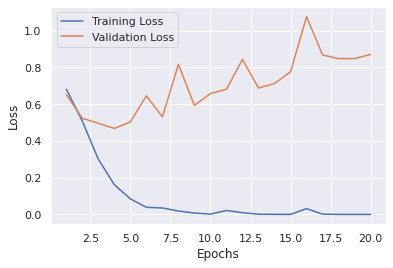

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

train_acc1  = model1_history.history['accuracy']
train_loss1 = model1_history.history['loss']
val_acc1  = model1_history.history['val_accuracy']
val_loss1 = model1_history.history['val_loss']

epochs = range(1, len(train_acc1) + 1)

plt.plot(epochs, train_loss1, label = 'Training Loss')
plt.plot(epochs, val_loss1, label = 'Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

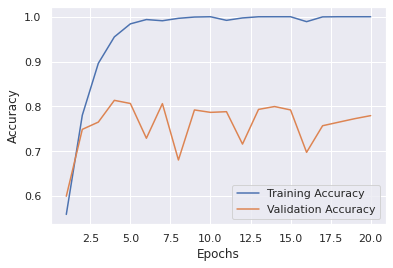

In [ ]:
plt.plot(epochs, train_acc1, label = 'Training Accuracy')
plt.plot(epochs, val_acc1, label = 'Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

In [ ]:
# Evaluate the model on the test set
model1.evaluate(x_test, y_test)

782/782 [==============================] - 7s 9ms/step - loss: 0.8891 - accuracy: 0.7762


[0.8891065716743469, 0.7761600017547607]

The simple RNN model achieves 77.6% accuracy on the test data.

## Using an `Embedding` Layer with Masking Enabled

In this section, we create the same RNN model, but this time we will enable masking. This is expected to improve the performance of our simple RNN.

In [ ]:
from tensorflow.keras import models
from tensorflow.keras import layers

model2 = models.Sequential()

model2.add(layers.Embedding(10000, 128, input_length=100, mask_zero=True))

model2.add(layers.SimpleRNN(64))

model2.add(layers.Dense(1, activation='sigmoid'))

In [ ]:
model2.compile(loss='binary_crossentropy', optimizer='rmsprop',  metrics=['accuracy'])

In [ ]:
model2_history = model2.fit(partial_x_train,
                            partial_y_train,
                            epochs=20,
                            batch_size=512,
                            validation_data=(x_val, y_val))

Epoch 1/20
30/30 [==============================] - 9s 242ms/step - loss: 0.6696 - accuracy: 0.5893 - val_loss: 0.7050 - val_accuracy: 0.5533
Epoch 2/20
30/30 [==============================] - 8s 282ms/step - loss: 0.4924 - accuracy: 0.7923 - val_loss: 0.4443 - val_accuracy: 0.8145
Epoch 3/20
30/30 [==============================] - 7s 220ms/step - loss: 0.3052 - accuracy: 0.8887 - val_loss: 0.4659 - val_accuracy: 0.7821
Epoch 4/20
30/30 [==============================] - 7s 217ms/step - loss: 0.1750 - accuracy: 0.9480 - val_loss: 0.5755 - val_accuracy: 0.7173
Epoch 5/20
30/30 [==============================] - 7s 218ms/step - loss: 0.0892 - accuracy: 0.9807 - val_loss: 0.5914 - val_accuracy: 0.7284
Epoch 6/20
30/30 [==============================] - 6s 214ms/step - loss: 0.0892 - accuracy: 0.9723 - val_loss: 0.4768 - val_accuracy: 0.8085
Epoch 7/20
30/30 [==============================] - 6s 210ms/step - loss: 0.0195 - accuracy: 0.9989 - val_loss: 0.5034 - val_accuracy: 0.8097
Epoch 

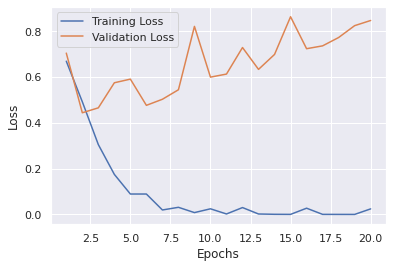

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

train_acc2  = model2_history.history['accuracy']
train_loss2 = model2_history.history['loss']
val_acc2  = model2_history.history['val_accuracy']
val_loss2 = model2_history.history['val_loss']

epochs = range(1, len(train_acc2) + 1)

plt.plot(epochs, train_loss2, label = 'Training Loss')
plt.plot(epochs, val_loss2, label = 'Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

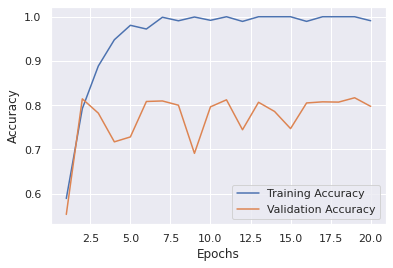

In [ ]:
plt.plot(epochs, train_acc2, label = 'Training Accuracy')
plt.plot(epochs, val_acc2, label = 'Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

In [ ]:
# Evaluate the model on the test set
model2.evaluate(x_test, y_test)

782/782 [==============================] - 13s 16ms/step - loss: 0.8756 - accuracy: 0.7899


[0.8755772709846497, 0.7899199724197388]

We can see that by masking the zero paddings, our simple RNN model achieves an accuracy of about 79% on the test dataset.

## An LSTM model

Next, replace the RNN layer with an LSTM layer with the same number of units (64). We use the same `Embedding` layer as before.

In [ ]:
model3 = models.Sequential()

model3.add(layers.Embedding(10000, 128, input_length=100))

model3.add(layers.LSTM(64))

# The output unit must have 'sigmoid' activation since this is a binary classification
model3.add(layers.Dense(1, activation='sigmoid'))

In [ ]:
model3.compile(loss='binary_crossentropy', optimizer='rmsprop',  metrics=['accuracy'])

In [ ]:
model3_history = model3.fit(partial_x_train,
                            partial_y_train,
                            epochs=20,
                            batch_size=512,
                            validation_data=(x_val, y_val))

Epoch 1/20
30/30 [==============================] - 3s 36ms/step - loss: 0.5908 - accuracy: 0.6961 - val_loss: 0.4274 - val_accuracy: 0.8155
Epoch 2/20
30/30 [==============================] - 1s 19ms/step - loss: 0.3831 - accuracy: 0.8425 - val_loss: 0.3883 - val_accuracy: 0.8260
Epoch 3/20
30/30 [==============================] - 1s 18ms/step - loss: 0.2991 - accuracy: 0.8802 - val_loss: 0.3689 - val_accuracy: 0.8469
Epoch 4/20
30/30 [==============================] - 1s 18ms/step - loss: 0.2485 - accuracy: 0.9075 - val_loss: 0.5153 - val_accuracy: 0.7805
Epoch 5/20
30/30 [==============================] - 1s 19ms/step - loss: 0.2272 - accuracy: 0.9135 - val_loss: 0.4041 - val_accuracy: 0.8463
Epoch 6/20
30/30 [==============================] - 1s 19ms/step - loss: 0.1901 - accuracy: 0.9293 - val_loss: 0.4341 - val_accuracy: 0.7979
Epoch 7/20
30/30 [==============================] - 1s 18ms/step - loss: 0.1808 - accuracy: 0.9348 - val_loss: 0.4117 - val_accuracy: 0.8310
Epoch 8/20
30

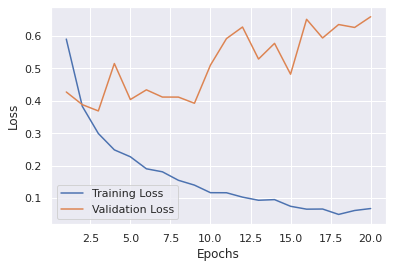

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

train_acc3  = model3_history.history['accuracy']
train_loss3 = model3_history.history['loss']
val_acc3  = model3_history.history['val_accuracy']
val_loss3 = model3_history.history['val_loss']

epochs = range(1, len(train_acc3) + 1)

plt.plot(epochs, train_loss3, label = 'Training Loss')
plt.plot(epochs, val_loss3, label = 'Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

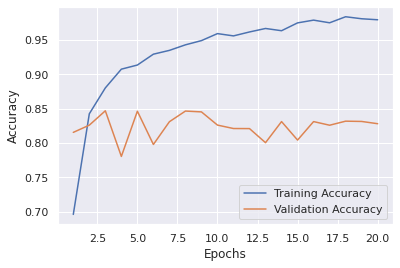

In [ ]:
plt.plot(epochs, train_acc3, label = 'Training Accuracy')
plt.plot(epochs, val_acc3, label = 'Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

In [ ]:
# Evaluate the model on the test set
model3.evaluate(x_test, y_test)

782/782 [==============================] - 14s 18ms/step - loss: 0.6930 - accuracy: 0.8164


[0.6930272579193115, 0.8163999915122986]

The LSTM model achieves 81.6% accuracy on the test data.

## A stack of LSTM layers

It is sometimes useful to stack several recurrent layers one after
the other in order to increase the representational power of a
network. In such a setup, you have to get all intermediate layers to return full sequences. To do so, we will have to set the `return_sequences` argument to `True` for all the intermediate LSTM layers and set it to `False` for the last LSTM layer (or just don't define it since the default is `return_sequences=False`).

In here, we are going to stack 3 layers of LSTM on top of each other, then connect the network to a classifier.

In [ ]:
model4 = models.Sequential()

model4.add(layers.Embedding(10000, 128, input_length=100))

model4.add(layers.LSTM(64, return_sequences=True))
model4.add(layers.LSTM(64, return_sequences=True))
model4.add(layers.LSTM(64))

# The output unit must have 'sigmoid' activation since this is a binary classification
model4.add(layers.Dense(1, activation='sigmoid'))

In [ ]:
model4.compile(loss='binary_crossentropy', optimizer='rmsprop',  metrics=['accuracy'])

In [ ]:
model4_history = model4.fit(partial_x_train,
                            partial_y_train,
                            epochs=20,
                            batch_size=512,
                            validation_data=(x_val, y_val))

Epoch 1/20
30/30 [==============================] - 50s 2s/step - loss: 0.6027 - accuracy: 0.6589 - val_loss: 0.4530 - val_accuracy: 0.7898
Epoch 2/20
30/30 [==============================] - 50s 2s/step - loss: 0.3890 - accuracy: 0.8301 - val_loss: 0.3839 - val_accuracy: 0.8276
Epoch 3/20
30/30 [==============================] - 50s 2s/step - loss: 0.3032 - accuracy: 0.8749 - val_loss: 0.3611 - val_accuracy: 0.8388
Epoch 4/20
30/30 [==============================] - 50s 2s/step - loss: 0.2728 - accuracy: 0.8925 - val_loss: 0.3840 - val_accuracy: 0.8406
Epoch 5/20
30/30 [==============================] - 50s 2s/step - loss: 0.2117 - accuracy: 0.9188 - val_loss: 0.4879 - val_accuracy: 0.8105
Epoch 6/20
30/30 [==============================] - 50s 2s/step - loss: 0.1819 - accuracy: 0.9299 - val_loss: 0.4701 - val_accuracy: 0.8220
Epoch 7/20
30/30 [==============================] - 50s 2s/step - loss: 0.1504 - accuracy: 0.9439 - val_loss: 0.4478 - val_accuracy: 0.8356
Epoch 8/20
30/30 [==

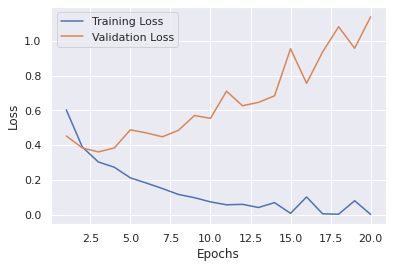

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

train_acc4  = model4_history.history['accuracy']
train_loss4 = model4_history.history['loss']
val_acc4  = model4_history.history['val_accuracy']
val_loss4 = model4_history.history['val_loss']

epochs = range(1, len(train_acc4) + 1)

plt.plot(epochs, train_loss4, label = 'Training Loss')
plt.plot(epochs, val_loss4, label = 'Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

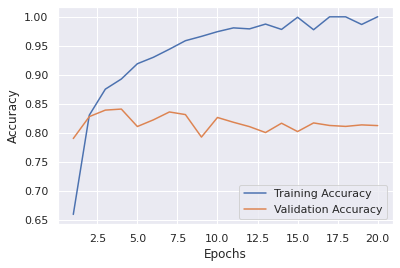

In [ ]:
plt.plot(epochs, train_acc4, label = 'Training Accuracy')
plt.plot(epochs, val_acc4, label = 'Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

In [ ]:
# Evaluate the model on the test set
model4.evaluate(x_test, y_test)

782/782 [==============================] - 31s 40ms/step - loss: 1.1879 - accuracy: 0.8022


[1.1879034042358398, 0.8021600246429443]

The model with 3 LSTM layers achieves 80.2% accuracy on the test data.

## Recurrent Dropout

It is evident from our training and validation curves that our model is overfitting: the training and validation losses start diverging
considerably after a few epochs. You are already familiar with a classic technique for fighting this phenomenon: dropout, consisting in
randomly zeroing-out input units of a layer in order to break happenstance correlations in the training data that the layer is exposed to.
How to correctly apply dropout in recurrent networks, however, is not a trivial question. It has long been known that applying dropout
before a recurrent layer hinders learning rather than helping with regularization. In 2015, Yarin Gal, as part of his [Ph.D. thesis](http://mlg.eng.cam.ac.uk/yarin/thesis/thesis.pdf) on
Bayesian deep learning, determined the proper way to use dropout with a recurrent network: the same dropout mask (the same pattern of
dropped units) should be applied at every timestep, instead of a dropout mask that would vary randomly from timestep to timestep. What's
more: in order to regularize the representations formed by the recurrent gates of layers such as LSTM, a temporally constant
dropout mask should be applied to the inner recurrent activations of the layer (a "recurrent" dropout mask). Using the same dropout mask at
every timestep allows the network to properly propagate its learning error through time; a temporally random dropout mask would instead
disrupt this error signal and be harmful to the learning process.

Yarin Gal did his research using Keras and helped build this mechanism directly into Keras recurrent layers. Every recurrent layer in Keras
has two dropout-related arguments: `dropout`, a float specifying the dropout rate for input units of the layer, and `recurrent_dropout`,
specifying the dropout rate of the recurrent units. Let's add dropout and recurrent dropout to our LSTM layer and see how it impacts
overfitting.

In [ ]:
model5 = models.Sequential()

model5.add(layers.Embedding(input_dim=10000, output_dim=128, input_length=100))

model5.add(layers.LSTM(64, dropout=0.5, recurrent_dropout=0.5))

model5.add(layers.Dense(1, activation='sigmoid'))

In [ ]:
model5.compile(loss='binary_crossentropy', optimizer='rmsprop',  metrics=['accuracy'])

Below, I am implementing early stopping as well by terminating the training process after 5 epochs.

In [ ]:
model5_history = model5.fit(partial_x_train,
                            partial_y_train,
                            epochs=5,
                            batch_size=512,
                            validation_data=(x_val, y_val))

Epoch 1/5
30/30 [==============================] - 25s 710ms/step - loss: 0.6129 - accuracy: 0.6803 - val_loss: 0.4457 - val_accuracy: 0.8129
Epoch 2/5
30/30 [==============================] - 21s 690ms/step - loss: 0.4192 - accuracy: 0.8252 - val_loss: 0.3605 - val_accuracy: 0.8409
Epoch 3/5
30/30 [==============================] - 20s 675ms/step - loss: 0.3390 - accuracy: 0.8627 - val_loss: 0.3589 - val_accuracy: 0.8420
Epoch 4/5
30/30 [==============================] - 20s 682ms/step - loss: 0.2896 - accuracy: 0.8862 - val_loss: 0.4779 - val_accuracy: 0.8309
Epoch 5/5
30/30 [==============================] - 21s 706ms/step - loss: 0.2627 - accuracy: 0.9004 - val_loss: 0.3464 - val_accuracy: 0.8505


Now, let's evaluate our model on the test data.

In [ ]:
# Evaluate the model on the test set
model5.evaluate(x_test, y_test)

782/782 [==============================] - 29s 37ms/step - loss: 0.3652 - accuracy: 0.8408


[0.36516809463500977, 0.8407599925994873]

We see that using recurrent dropout and early stopping, we achieved 84% accuracy on the test dataset.